In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [5]:
def pad(image, padding=2):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

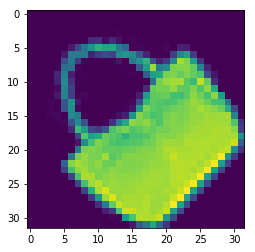

In [6]:
plt.imshow(cv2_rotate(pad(X_train[100]), 45))

In [7]:
augmented_rotations_per_sample = 3

In [8]:
def generate_random_rotations(X, Y, n_rotations_per_sample, rot_range=10):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(-rot_range, rot_range)
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [9]:
X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, augmented_rotations_per_sample)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, augmented_rotations_per_sample)

Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

100%|██████████| 10000/10000 [00:00<00:00, 14052.22it/s]


In [10]:
nb_classes = Y_train_onehot.shape[1]

In [11]:
R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

In [12]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [13]:
R_train_sin_cos = create_rot_sin_cos(R_train_radians)
R_test_sin_cos = create_rot_sin_cos(R_test_radians)

In [30]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

def cosine_proximity_unitary(y_true, y_pred):
    
    dot_product_loss = losses.cosine_proximity(y_true, y_pred)
    unit_circle_loss = K.square(1 - (K.square(y_pred[:, 0]) + K.square(y_pred[:, 1])))
    return dot_product_loss + 0.05 * unit_circle_loss


def build_model(use_labels=True, use_rotation=True):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.25)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(2, name='r')(r)
        #r = layers.Lambda(lambda l: l / K.sqrt(K.sum(l**2)), name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'cosine_proximity'], 
                      metrics=['accuracy'], loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    model.summary()
    
    return model

In [31]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [32]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train_sin_cos]
        y_test = [Y_test_onehot, R_test_sin_cos]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train_sin_cos
        y_test = R_test_sin_cos
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [35]:
histories = []
diff_degrees = []
y_preds = []
r_preds = []

use_labels = True
use_rotation = True

rot_step = 10

for rot_range in range(180, 180 + rot_step, rot_step):
    
    print('Training on rotation range of +-', rot_range)
    
    for _ in range(5):

        X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                                      augmented_rotations_per_sample, rot_range)
        X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                                   augmented_rotations_per_sample, rot_range)

        Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
        Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

        nb_classes = Y_train_onehot.shape[1]

        R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

        R_train_sin_cos = create_rot_sin_cos(R_train_radians)
        R_test_sin_cos = create_rot_sin_cos(R_test_radians)

        alpha = K.variable(0.9)
        beta = K.variable(0.1)
        model = build_model(use_labels, use_rotation)

        history = train_model(model, use_labels, use_rotation).history
        histories.append(history)

        Y_pred, R_pred = model.predict(X_test_rot)
        diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
        diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
        print(np.mean(diff_degree))

        diff_degrees.append(diff_degree)
        y_preds.append(Y_pred)
        r_preds.append(R_pred)


  2%|▏         | 1415/60000 [00:00<00:04, 14144.42it/s]

Training on rotation range of +- 180


100%|██████████| 10000/10000 [00:00<00:00, 14126.79it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_16

  2%|▏         | 1474/60000 [00:00<00:03, 14729.06it/s]

10.947949556905497


100%|██████████| 10000/10000 [00:00<00:00, 14037.44it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
dropout_19

  2%|▏         | 1456/60000 [00:00<00:04, 14548.78it/s]

11.958580089699197


100%|██████████| 10000/10000 [00:00<00:00, 13934.62it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_22

  2%|▏         | 1174/60000 [00:00<00:05, 11730.39it/s]

10.500555947852522


100%|██████████| 10000/10000 [00:00<00:00, 13889.15it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
dropout_25

  5%|▍         | 2872/60000 [00:00<00:03, 14354.13it/s]

11.280339004404958


100%|██████████| 10000/10000 [00:00<00:00, 13799.58it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_28

In [34]:
print([history['val_r_loss'][-1] for history in histories])
print([history['val_y_acc'][-1] for history in histories])
print(np.mean(diff_degrees, axis=1))
print(np.std(diff_degrees, axis=1))

[-0.9370076061248779, -0.9345939945538839, -0.9303587948799134, -0.9395129657745361, -0.931304681746165]
[0.8405666666666667, 0.8407333333015442, 0.8406000000317891, 0.8393000000317892, 0.8398333333333333]
[10.78058838 11.15287478 11.7274108  10.81723969 11.8485133 ]
[21.23612629 21.39614367 22.06983143 20.51632304 21.80496776]


In [36]:
print([history['val_r_loss'][-1] for history in histories])
print([history['val_y_acc'][-1] for history in histories])
print(np.mean(diff_degrees, axis=1))
print(np.std(diff_degrees, axis=1))

[-0.9362403658866882, -0.9303425656636556, -0.9392968688646952, -0.9346962436676025, -0.9383628163337707]
[0.8406999999682109, 0.8356666666348775, 0.8454000000317892, 0.8382999999682108, 0.8448999999682109]
[10.94794956 11.95858009 10.50055595 11.280339   10.74493003]
[21.30955773 21.79139391 20.82924657 21.3742534  20.71099712]


In [20]:
R_test_sin_cos[:10]

array([[ 0.39073113, -0.92050485],
       [ 0.74314483, -0.66913061],
       [-0.0348995 , -0.99939083],
       [ 0.42261826, -0.90630779],
       [ 0.48480962, -0.87461971],
       [-0.0348995 ,  0.99939083],
       [ 0.64278761, -0.76604444],
       [ 0.77714596, -0.62932039],
       [-0.92718385, -0.37460659],
       [ 0.99939083,  0.0348995 ]])

In [21]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_loss', 'val_r_acc', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [22]:
data = np.array(list(get_data_from_histories()))

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (18,) and (5,)

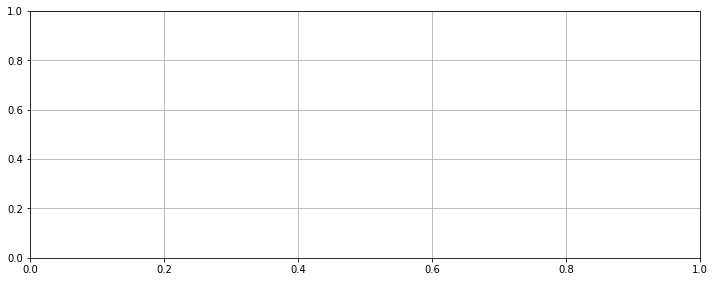

In [24]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 4], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 1], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [ ]:
np.mean(diff_degrees, axis=1)

In [ ]:
Y_pred, R_pred = model.predict(X_test_rot)

In [ ]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
print(np.mean(diff_degree))

In [ ]:
Y_pred[:20]

In [ ]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
plt.hist(diff_degree, bins=35)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_matrix = np.zeros((10, 10), dtype='int')

for y_true, y_pred in zip(Y_test_rot, Y_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Fashion MNIST)')
plt.imshow(confusion_matrix)
plt.colorbar()